In [52]:
!pip install -q  datasets accelerate loralib jmespath
!pip install -q git+https://github.com/huggingface/transformers.git@main git+https://github.com/huggingface/peft.git
!pip install -q bitsandbytes-windows

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.nn as nn
import bitsandbytes as bnb
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(
    "EleutherAI/gpt-j-6B",
    load_in_8bit=True, 
    device_map='auto',
)


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
binary_path: c:\Users\user\AppData\Local\Programs\Python\Python38\lib\site-packages\bitsandbytes\cuda_setup\libbitsandbytes_cuda116.dll
CUDA SETUP: Loading binary c:\Users\user\AppData\Local\Programs\Python\Python38\lib\site-packages\bitsandbytes\cuda_setup\libbitsandbytes_cuda116.dll...


In [2]:
for param in model.parameters():
  param.requires_grad = False 
  if param.ndim == 1:
    param.data = param.data.to(torch.float16)

model.gradient_checkpointing_enable()  
model.enable_input_require_grads()

class CastOutputToFloat(nn.Sequential):
  def forward(self, x): return super().forward(x).to(torch.float16)
model.lm_head = CastOutputToFloat(model.lm_head)

In [3]:
from peft import LoraConfig, get_peft_model 

config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)


In [4]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

print_trainable_parameters(model)

trainable params: 7340032 || all params: 6058222816 || trainable%: 0.12115817167725645


In [5]:
import json 

def load_json_data(path):
    with open(path) as f:
        json_data = json.load(f)
    return json_data['data']

json_datas = load_json_data('data/train-v2.0.json')

In [6]:
from sklearn.model_selection import train_test_split
train_data = []
for json_data in json_datas:
    paragraphs = json_data['paragraphs'][0]
    context = paragraphs['context']
    qas = paragraphs['qas']
    for qa in qas:
        question = qa['question']   

        if qa['is_impossible']:
            answer = 'answers not in context'
        else:
            answer = qa['answers'][0]['text']

        output = f'Read the context and question to find the correct answer:\n context:{context} question:{question} answer:{answer}' 
        train_data.append(output)
        
x_train, x_valid = train_test_split(train_data, train_size=0.8, random_state=46, shuffle=False)

In [6]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-j-6B")
tokenizer.pad_token = tokenizer.eos_token

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
from torch.utils.data import Dataset, DataLoader
import torch
class QAdataset(Dataset):
    def __init__(self, x):
        self.x = x

          
    def __getitem__(self, index):
        return self.x[index]
            
       
    def __len__(self):
        return len(self.x)
    
trainset = QAdataset(x_train)
validset = QAdataset(x_valid)

In [25]:
def collate_fn(batch):    
    x = list(batch)
    x = tokenizer(x, truncation=True, padding="longest", return_tensors='pt')
   
    return {**x, 'labels':x.input_ids}
    
train_loader = DataLoader(trainset, batch_size = 8, shuffle = True, num_workers = 0, collate_fn = collate_fn)
valid_loader = DataLoader(validset, batch_size = 8, shuffle = True, num_workers = 0, collate_fn = collate_fn)

In [28]:
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [29]:
from tqdm import tqdm
import matplotlib.pyplot as plt 

def train(epoch):
    train_loss = 0
    train_pbar = tqdm(train_loader, position=0, leave=True) # 宣告進度條
    
    model.train() 
    for input_datas in train_pbar: 
        for key in input_datas.keys():
            input_datas[key] = input_datas[key].to(device)
        optimizer.zero_grad() 
        
        outputs = model(**input_datas) 
        
        loss = outputs.loss

        loss.backward()
        optimizer.step() 
        
        train_pbar.set_description(f'Train Epoch {epoch}') 
        train_pbar.set_postfix({'loss':f'{loss:.3f}'})

        train_loss += loss.item()  
    return train_loss/len(train_loader)

def valid(epoch):
    valid_loss = 0
    valid_pbar = tqdm(valid_loader, position=0, leave=True)
    
    model.eval()
    with torch.no_grad(): 
        for input_datas in valid_pbar:
            for key in input_datas.keys():
                input_datas[key] = input_datas[key].to(device)
        
            outputs = model(**input_datas) 
            loss = outputs.loss
            
            valid_pbar.set_description(f'Valid Epoch {epoch}')
            valid_pbar.set_postfix({'loss':f'{loss:.3f}'})

            valid_loss += loss.item()

    return valid_loss/len(valid_loader)


def show_training_loss(loss_record):
    train_loss, valid_loss = [i for i in loss_record.values()]
    
    plt.plot(train_loss)
    plt.plot(valid_loss)
    #標題
    plt.title('Result')
    #y軸標籤
    plt.ylabel('Loss')
    #x軸標籤
    plt.xlabel('Epoch')
    #顯示折線的名稱
    plt.legend(['train', 'valid'], loc='upper left')
    #顯示折線圖
    plt.show()

Valid Epoch 0: 100%|██████████| 97/97 [00:45<00:00,  2.12it/s, loss=1.303]


Saving Model With Loss 1.36042
Train Loss: 1.31501| Valid Loss: 1.36042| Best Loss: 1.36042



Valid Epoch 1: 100%|██████████| 97/97 [00:45<00:00,  2.13it/s, loss=1.131]


Train Loss: 0.65462| Valid Loss: 1.74736| Best Loss: 1.36042



Valid Epoch 2: 100%|██████████| 97/97 [00:45<00:00,  2.15it/s, loss=2.363]


Train Loss: 0.29500| Valid Loss: 1.95673| Best Loss: 1.36042



Valid Epoch 3: 100%|██████████| 97/97 [00:45<00:00,  2.11it/s, loss=2.809]


Train Loss: 0.17439| Valid Loss: 2.09798| Best Loss: 1.36042



Valid Epoch 4: 100%|██████████| 97/97 [00:45<00:00,  2.11it/s, loss=2.658]


Train Loss: 0.13431| Valid Loss: 2.24295| Best Loss: 1.36042



Valid Epoch 5: 100%|██████████| 97/97 [00:45<00:00,  2.11it/s, loss=1.575]


Train Loss: 0.11732| Valid Loss: 2.26959| Best Loss: 1.36042



Valid Epoch 6: 100%|██████████| 97/97 [00:46<00:00,  2.09it/s, loss=2.889]


Train Loss: 0.10666| Valid Loss: 2.32638| Best Loss: 1.36042



Valid Epoch 7: 100%|██████████| 97/97 [00:45<00:00,  2.12it/s, loss=2.387]


Train Loss: 0.09907| Valid Loss: 2.38615| Best Loss: 1.36042



Valid Epoch 8: 100%|██████████| 97/97 [00:45<00:00,  2.11it/s, loss=2.891]


Train Loss: 0.08873| Valid Loss: 2.39994| Best Loss: 1.36042



Valid Epoch 9: 100%|██████████| 97/97 [00:46<00:00,  2.08it/s, loss=2.621]


Train Loss: 0.08090| Valid Loss: 2.43657| Best Loss: 1.36042



Valid Epoch 10: 100%|██████████| 97/97 [00:46<00:00,  2.10it/s, loss=3.531]

------------------------------------
|Model can't improve, stop training|
------------------------------------


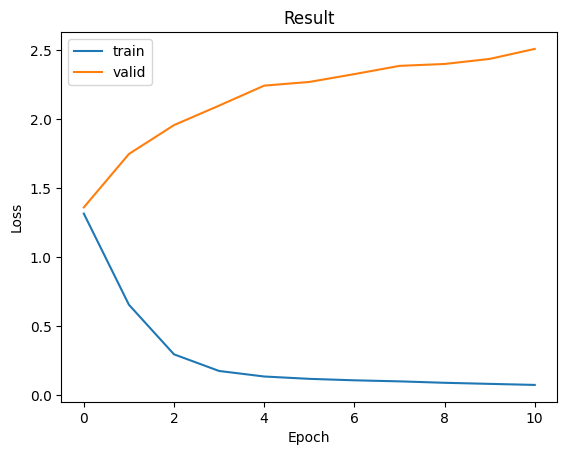

In [30]:
epochs = 100                             # 訓練次數
early_stopping = 10                      # 模型訓練幾次沒進步就停止
stop_cnt = 0                             # 計數模型是否有進步的計數器
model_path = 'model.ckpt'                # 模型存放路徑
show_loss = True                         # 是否顯示訓練折線圖
best_loss = float('inf')                 # 最佳的Loss
loss_record = {'train':[], 'valid':[]}   # 訓練紀錄

for epoch in range(epochs):   
    train_loss = train(epoch)
    valid_loss = valid(epoch)
    
    loss_record['train'].append(train_loss)
    loss_record['valid'].append(valid_loss)
    
    # 儲存最佳的模型權重
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), model_path)
        print(f'Saving Model With Loss {best_loss:.5f}')
        stop_cnt = 0
    else:
        stop_cnt+=1
    
    # Early stopping
    if stop_cnt == early_stopping:
        output = "Model can't improve, stop training"
        print('-' * (len(output)+2))
        print(f'|{output}|')
        print('-' * (len(output)+2))
        break

    print(f'Train Loss: {train_loss:.5f}' , end='| ')
    print(f'Valid Loss: {valid_loss:.5f}' , end='| ')
    print(f'Best Loss: {best_loss:.5f}', end='\n\n')


if show_loss:
    show_training_loss(loss_record)

In [ ]:
model.load_state_dict(torch.load(model_path))

In [59]:
inputs_text = 'context:A railway electrification system supplies electric power to railway trains and trams without an on-board prime mover or local fuel supply. Electrification has many advantages but requires significant capital expenditure. Selection of an electrification system is based on economics of energy supply, maintenance, and capital cost compared to the revenue obtained for freight and passenger traffic. Different systems are used for urban and intercity areas; some electric locomotives can switch to different supply voltages to allow flexibility in operation. question:A railway electrification system supplies power to trains and trams with an on-board what'
input_ids = tokenizer(inputs_text, return_tensors="pt")
generated_ids = model.generate(**input_ids, num_beams = 2, max_length = 132, repetition_penalty = 2.5, length_penalty = 1.0, early_stopping = True)
generated_tokens = tokenizer.decode(generated_ids[0], skip_special_tokens=True).split('answer:')
print(generated_tokens[0])
print(generated_tokens[1])
print(x_valid[0].split('answer:')[2])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
c:\Users\user\AppData\Local\Programs\Python\Python38\lib\site-packages\transformers\generation\utils.py:1539: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


context:A railway electrification system supplies electric power to railway trains and trams without an on-board prime mover or local fuel supply. Electrification has many advantages but requires significant capital expenditure. Selection of an electrification system is based on economics of energy supply, maintenance, and capital cost compared to the revenue obtained for freight and passenger traffic. Different systems are used for urban and intercity areas; some electric locomotives can switch to different supply voltages to allow flexibility in operation. question:A railway electrification system supplies power to trains and trams with an on-board what? 
answers not in context
answers not in context
